<a href="https://colab.research.google.com/github/lior9005/deep-learning/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADL final project


---


**Authors:**
> Lior Sharony 316380138


> Noam Zigler 208742429


> Eden Miran 314868019


## Imports ##

In [148]:
# Visualization and data analysis
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import display, Markdown

# PyTorch core and neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch import optim

# Data loading and handling
from torch.utils.data import DataLoader, Dataset, random_split, Subset, SubsetRandomSampler

#from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score

# Utilities
from tqdm.auto import tqdm
import numpy as np

## Project initialization ##

In [149]:
# Eval mode
eval_mode = False
ood_as_fashion = False #define the ood
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


# 5.2. Data & Preprocessing

In [150]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10


In [151]:
# Transformers
# Transformers for training set
mnist_transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformers for test set
mnist_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ood_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,))
])

num_of_train_samples = 10000
num_of_test_samples = 2000

# Mnist dataset
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform_train)
mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform_test)

torch.manual_seed(0)
np.random.seed(0)

# splitting to validation and training
train_size = len(mnist_train_set)
mnist_val_size = int(train_size * 0.2)
mnist_train_size = train_size - mnist_val_size
mnist_train_dataset, mnist_val_dataset = random_split(mnist_train_set, [mnist_train_size, mnist_val_size])

train_idx = np.arange(len(mnist_train_dataset))
train_subset_idx = np.random.choice(train_idx,num_of_train_samples)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=512, sampler=train_subset_sampler)
mnist_val_loader = DataLoader(mnist_val_dataset, batch_size=512, shuffle=False)

# OOD
if(ood_as_fashion):
  ood = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)
else:
  ood = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)

# Generating the combined dataset
ood_indices = np.random.choice(len(ood), num_of_test_samples , replace=False)
ood_subset = Subset(ood, ood_indices)
mnist_test_subset_idx = np.random.choice(len(mnist_test_set), num_of_test_samples, replace=False)
mnist_test_subset = Subset(mnist_test_set, mnist_test_subset_idx)

mnist_test_loader = DataLoader(mnist_test_subset, batch_size=1000, shuffle=False)

combined_ds = CombinedDataset(mnist_test_subset, ood_subset)
combined_ds_loader = DataLoader(combined_ds, batch_size=1024, shuffle=True)


Files already downloaded and verified


#5.3. Models

In [152]:
# Baseline model class
class Baseline_model(nn.Module):
  def __init__(self):
        super(Baseline_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
          )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.clf = nn.Sequential(
            nn.Linear(self._get_conv_output(), 10),
            nn.LogSoftmax(dim=1)
        )

  def _get_conv_output(self, shape = (1,28,28)):
    #Computes the size of the flattened features after the convolutional layers.
      with torch.no_grad():
          batch_size = 1
          input = torch.rand(batch_size, *shape)
          output_feat = self.encoder(input)
          n_size = output_feat.view(batch_size, -1).shape[1]
      return n_size

  def forward(self,x):
      encoded_vector = self.encoder(x)
      encoded_vector_clf = encoded_vector.view(encoded_vector.size(0), -1)
      pred = self.clf(encoded_vector_clf)
      recon = self.decoder(encoded_vector)
      return pred, recon

class OSR_model(nn.Module):
    def __init__(self, recon_threshold = float('inf'), n_classes=11):
        super(OSR_model, self).__init__()

        # Encoder (same as in Baseline model)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder (same as in Baseline model)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        # Classifier (same as in Baseline model)
        self.clf = nn.Sequential(
            nn.Linear(self._get_conv_output(), n_classes),
            nn.LogSoftmax(dim=1)
        )

        # Reconstruction threshold (to decide if the sample is unknown)
        self.recon_threshold = recon_threshold
        self.n_classes = n_classes


    def _get_conv_output(self, shape=(1, 28, 28)):
        """Computes the size of the flattened features after the convolutional layers."""
        with torch.no_grad():
            batch_size = 1
            input = torch.rand(batch_size, *shape)
            output_feat = self.encoder(input)
            n_size = output_feat.view(batch_size, -1).shape[1]
        return n_size

    def forward(self, x):
        encoded_vector = self.encoder(x)
        encoded_vector_clf = encoded_vector.view(encoded_vector.size(0), -1)
        pred = self.clf(encoded_vector_clf)
        recon = self.decoder(encoded_vector)

        # Calculate reconstruction error
        recon_error = F.mse_loss(recon, x, reduction='none')
        recon_error = recon_error.view(recon_error.size(0), -1).mean(dim=1)  # Sum across pixels
        # Check if reconstruction error exceeds the threshold
        is_unknown_recon = recon_error > self.recon_threshold
        is_unknown = is_unknown_recon

        if not self.training:
            # Update predictions for unknown samples
            unknown_class_index = self.clf[0].out_features - 1  # Assuming the unknown class is the last index
            pred[is_unknown] = torch.full((pred.size(1),), -float('inf'), device=pred.device)  # Set log probabilities to -inf
            pred[is_unknown, unknown_class_index] = 0  # Set log probability of the unknown class to 0 (highest)
        return pred, recon, is_unknown, recon_error, encoded_vector_clf

    def determine_threshold(self, digit_loader, percentile):
        self.eval()
        recon_errors = []

        with torch.no_grad():
            for images, _ in digit_loader:
                images = images.to(next(self.parameters()).device)
                pred, recon, is_unknown, recon_error, encoded_vector_clf = self(images)

                # Calculate reconstruction error
                error = F.mse_loss(recon, images, reduction='none')
                error = error.view(error.size(0), -1).mean(dim=1)
                recon_errors.extend(error.cpu().numpy())

        recon_threshold = np.percentile(recon_errors, percentile)
        self.recon_threshold = recon_threshold
        return recon_threshold

#models summary
print("Baseline model summary:")
torchsummary.summary(Baseline_model().to(device), (1, 28, 28), device=device.type)
print("OSR model summary:")
torchsummary.summary(OSR_model().to(device), (1, 28, 28), device=device.type)

Baseline model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          36,928
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
        LogSoftmax-8                   [-1, 10]               0
   ConvTranspose2d-9           [-1, 64, 14, 14]          36,928
             ReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]             577
Total params: 106,443
Trainable params: 106,443
Non-trainable params: 0
----------------------------------------------------------------
Input 

#5.4. Training

In [153]:
def plot_training_results(result_dict, model_name):
    plt.plot(result_dict['train_acc'], label='Training Accuracy')
    plt.plot(result_dict['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f"{model_name} Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    final_train_acc = result_dict['train_acc'][-1]
    final_val_acc = result_dict['val_acc'][-1]
    offset = 0.5
    plt.text(len(result_dict['train_acc']) - 1, final_train_acc, f'{final_train_acc*100:.2f}%', ha='right', va='bottom')
    plt.text(len(result_dict['val_acc']) - 1, final_val_acc, f'{final_val_acc*100:.2f}%', ha='right', va='bottom')
    plt.show()

    plt.plot(result_dict['train_clf_loss'], label='Training clf Loss')
    plt.plot(result_dict['train_recon_loss'], label='Training recon Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name} Training Loss")
    plt.legend()
    plt.grid(True)
    final_clf_train_loss =result_dict['train_clf_loss'][-1]
    final_recon_train_loss = result_dict['train_recon_loss'][-1]
    plt.text(len(result_dict['train_clf_loss']) - 1, final_clf_train_loss, f'{final_clf_train_loss:.2f}', ha='right', va='bottom')
    plt.text(len(result_dict['train_recon_loss']) - 1, final_recon_train_loss, f'{final_recon_train_loss:.2f}', ha='right', va='bottom')
    plt.show()

## Baseline training function ##

In [154]:
def train_baseline_model(model, train_loader, val_loader, clf_criterion, recon_criterion, optimizer, num_epochs):
  results_dict = {
      'train_clf_loss': [],
      'val_clf_loss': [],
      'train_recon_loss': [],
      'val_recon_loss': [],
      'val_acc': [],
      'train_acc': []
  }

  for epoch in tqdm(range(num_epochs), desc="Training Baseline model"):
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
              dataloader = train_loader
          else:
              model.eval()
              dataloader = val_loader

          running_loss = 0.0
          running_corrects = 0
          total_samples = 0
          running_recon_loss = 0.0

          for inputs, labels in dataloader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                  outputs, recon = model(inputs)
                  clf_loss = clf_criterion(outputs, labels)
                  recon_loss = recon_criterion(recon, inputs)
                  total_loss = clf_loss + recon_loss

                  if phase == 'train':
                      total_loss.backward()
                      optimizer.step()

              running_loss += total_loss.item() * inputs.size(0)
              running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
              running_recon_loss += recon_loss.item() * inputs.size(0)
              total_samples += labels.size(0)

          epoch_clf_loss = running_loss / total_samples
          epoch_clf_acc = running_corrects.double() / total_samples
          epoch_recon_loss = running_recon_loss / total_samples
          results_dict[f'{phase}_clf_loss'].append(epoch_clf_loss)
          results_dict[f'{phase}_acc'].append(epoch_clf_acc.item())
          results_dict[f'{phase}_recon_loss'].append(epoch_recon_loss)
  return results_dict

## OSR training function ##

In [155]:
def train_osr_model(model, train_loader, val_loader, clf_criterion, recon_criterion, optimizer, num_epochs):
    results_dict = {
        'train_clf_loss': [],
        'val_clf_loss': [],
        'train_recon_loss': [],
        'val_recon_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_unknown': [],
        'val_unknown': []
    }

    for epoch in tqdm(range(num_epochs), desc="Training OSR Model"):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            running_recon_loss = 0.0
            running_unknown = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred, recon, is_unknown, recon_error, encoded_vector_clf = model(inputs)
                    clf_loss = clf_criterion(pred, labels)
                    recon_loss = recon_criterion(recon, inputs)
                    total_loss = clf_loss + recon_loss

                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                    running_loss += total_loss.item() * inputs.size(0)
                    running_corrects += torch.sum(torch.argmax(pred, 1) == labels.data)
                    running_recon_loss += recon_loss.item() * inputs.size(0)
                    running_unknown += torch.sum(is_unknown).item()
                    total_samples += labels.size(0)

            epoch_clf_loss = running_loss / total_samples
            epoch_clf_acc = running_corrects.double() / total_samples
            epoch_recon_loss = running_recon_loss / total_samples
            epoch_unknown = running_unknown / total_samples
            results_dict[f'{phase}_clf_loss'].append(epoch_clf_loss)
            results_dict[f'{phase}_acc'].append(epoch_clf_acc.item())
            results_dict[f'{phase}_recon_loss'].append(epoch_recon_loss)
            results_dict[f'{phase}_unknown'].append(epoch_unknown)

    # determine the threshold
    model.recon_threshold = model.determine_threshold(val_loader, percentile=98.5)
    return results_dict

## Training procedure ##

In [156]:
if not eval_mode:
  # training parameters
  epochs = 50
  lr = 0.1
  clf_criterion = nn.NLLLoss()
  recon_criterion = nn.MSELoss()

  baseline_model = Baseline_model().to(device)
  baseline_optimizer = optim.SGD(baseline_model.parameters(), lr=lr, momentum=0.9)
  osr_model = OSR_model().to(device)
  OSR_optimizer = optim.SGD(osr_model.parameters(), lr=lr, momentum=0.9)

  # train
  baseline_result_dict = train_baseline_model(baseline_model,mnist_train_loader, mnist_val_loader, clf_criterion, recon_criterion, baseline_optimizer, epochs)
  OSR_result_dict = train_osr_model(osr_model,mnist_train_loader, mnist_val_loader, clf_criterion, recon_criterion, OSR_optimizer, epochs)

  # save the weights
  torch.save(baseline_model.state_dict(), './baseline model.pth')
  torch.save({
    'model_state_dict': osr_model.state_dict(),
    'recon_threshold': osr_model.recon_threshold
    },
    './OSR model.pth')


Training Baseline model:   0%|          | 0/50 [00:00<?, ?it/s]

Training OSR Model:   0%|          | 0/50 [00:00<?, ?it/s]

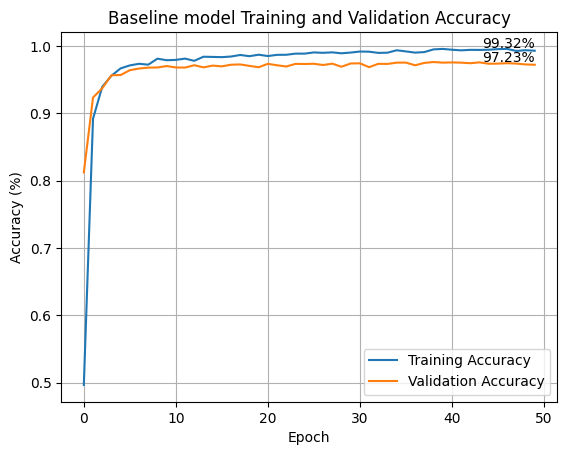

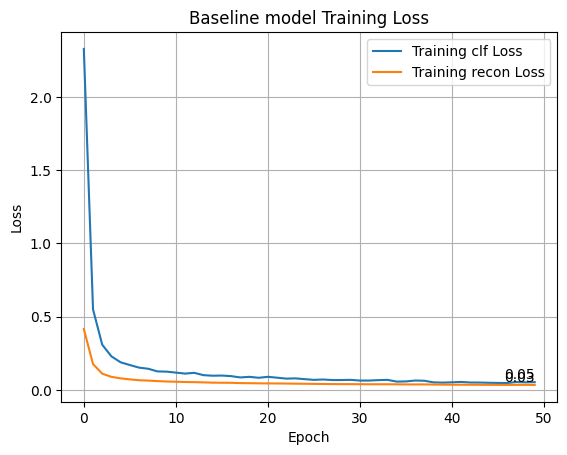

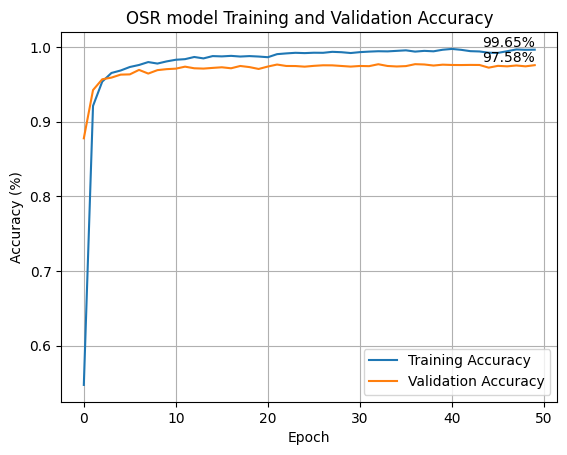

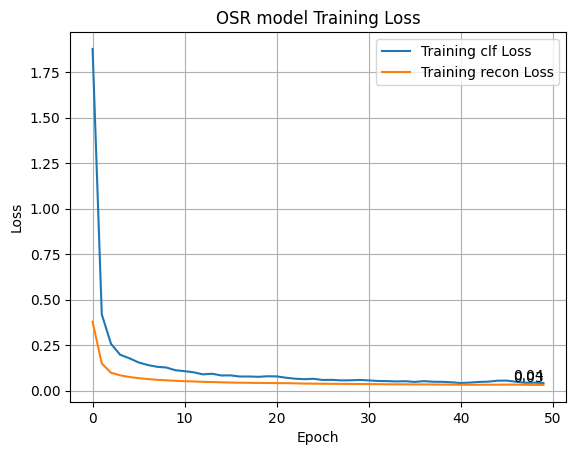

***
**OSR Model Threshold:** 0.0596
***

In [157]:
if not eval_mode:
  # plotting
  plot_training_results(baseline_result_dict, "Baseline model")

  plot_training_results(OSR_result_dict, "OSR model")
  display(Markdown(f"***\n**OSR Model Threshold:** {osr_model.recon_threshold:.4f}\n***"))

#5.5 Evaluation - CIFAR10/Fashion-MNIST

##Baseline results:##

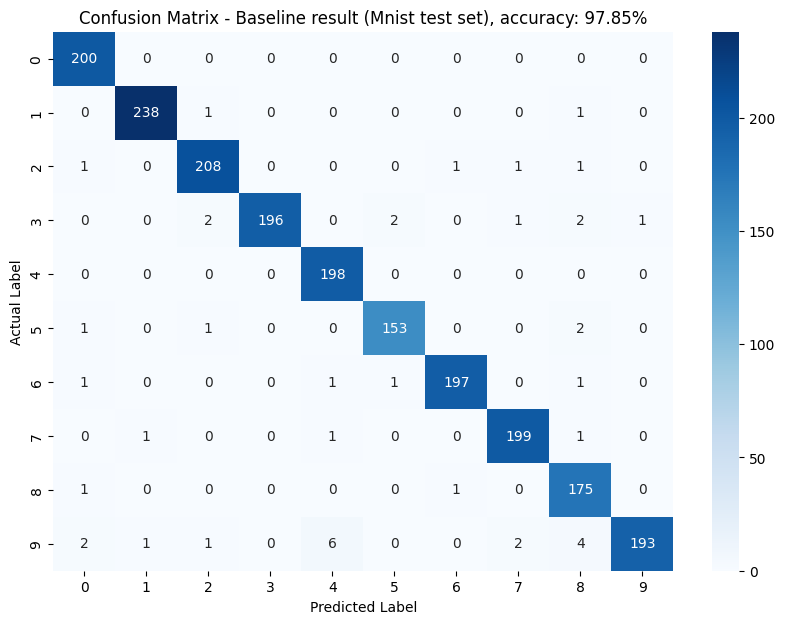

In [158]:
if (eval_mode):
    # Load the trained models weights
    baseline_model = Baseline_model()
    baseline_model.load_state_dict(torch.load('./baseline model.pth'))
    baseline_model.to(device)
    baseline_model.eval()
    osr_model = OSR_model()
    osr_model.load_state_dict(torch.load('./OSR model.pth')['model_state_dict'])
    osr_model.recon_threshold = torch.load('./OSR model.pth')['recon_threshold']
    osr_model.to(device)
    osr_model.eval()

def eval_baseline(model, testloader):
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            labels = labels.to(device)
            images = images.to(device)
            outputs, _  = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate predictions and labels for confusion matrix
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)

    return accuracy, cm

# Baseline results
accuracy, cm = eval_baseline(baseline_model, mnist_test_loader)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.title(f"Confusion Matrix - Baseline result (Mnist test set), accuracy: {accuracy:.2f}%")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


##5.5.3. OSR approach:##

The method we selected for the open-set recognition approach involves utilizing a reconstruction loss as a confidence threshold to distinguish between in-distribution samples and out-of-distribution (OOD) samples. The threshold is set at a percentile value of the reconstruction loss distribution, effectively defining the boundary for OOD detection. the percentile was determined through multiple experiments.



## OOD result ##

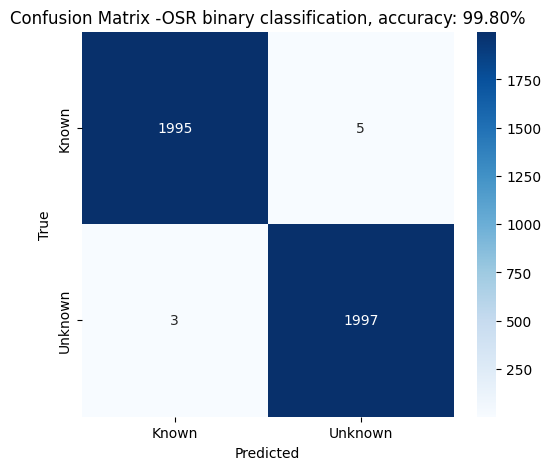

In [159]:
def map_to_binary_class(predictions, true_labels, known_class=0, unknown_class=1):
    # Map MNIST labels to known (0) and OOD labels to unknown (1)
    true_labels_mapped = torch.where(true_labels < 10, known_class, unknown_class)  # MNIST labels are < 10
    predictions_mapped = torch.where(predictions < 10, known_class, unknown_class)  # Same for predicted values
    return true_labels_mapped, predictions_mapped

def OOD_res(model, testloader):
  # Collect true labels and predictions
  all_true_labels = []
  all_predictions = []

  with torch.no_grad():
      for images, labels in combined_ds_loader:
          images, labels = images.to(device), labels.to(device)
          # Get model predictions
          outputs, _, _, _, _ = model(images)
          _, predicted = torch.max(outputs, 1)

          # Map labels and predictions to binary classes
          true_labels_mapped, predictions_mapped = map_to_binary_class(predicted, labels)

          all_true_labels.extend(true_labels_mapped.cpu().numpy())
          all_predictions.extend(predictions_mapped.cpu().numpy())

  # Calculate binary classification accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)

  # Generate confusion matrix
  cm = confusion_matrix(all_true_labels, all_predictions)

  # Plot the confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f"Confusion Matrix -OSR binary classification, accuracy: {accuracy * 100:.2f}%")
  plt.show()

OOD_res(osr_model, combined_ds_loader)

## OSR results ##

Accuracy on MNIST data: 98.35%
Accuracy on OOD (Unknown) data: 99.85%


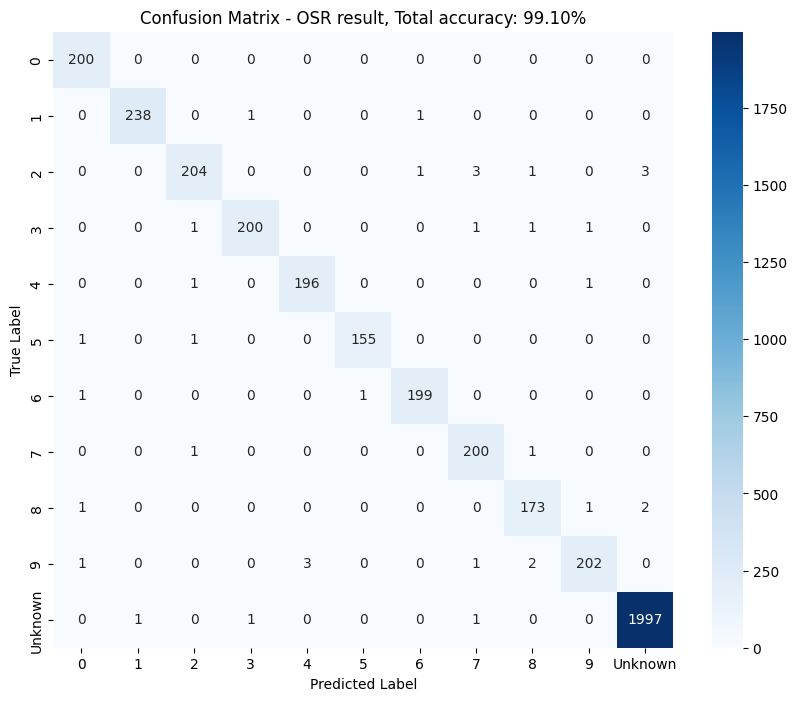

In [160]:
# OSR results

def eval_model(model, data_loader, device): # pre defined function (utils.py)

    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            outputs, _, _, _, _ = model(data)

            probas, y_pred = torch.max(outputs, 1)

            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

def OSR_cm(model, testloader, acc_mnist, acc_ood, acc_total):

    # Generate confusion matrix (11 classes: 10 MNIST classes + 1 OOD class)
    conf_matrix = np.zeros((11, 11), dtype=int)

    # Collect all predictions and labels for confusion matrix
    model.eval()
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(device), labels.to(device)


            outputs, _, _, _, _ = model(data)
            probas, y_pred = torch.max(outputs, 1)

            # Separate MNIST and OOD samples
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist

            labels_mnist = labels[mask_mnist]
            labels_ood = torch.full_like(labels[mask_ood], 10)  # Treat OOD as class 10

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            # Update confusion matrix for MNIST
            for true, pred in zip(labels_mnist, pred_mnist):
                conf_matrix[true.item(), pred.item()] += 1
            # Update confusion matrix for OOD
            for true, pred in zip(labels_ood, pred_ood):
                conf_matrix[true.item(), pred.item()] += 1
    print(f"Accuracy on MNIST data: {acc_mnist * 100:.2f}%")
    print(f"Accuracy on OOD (Unknown) data: {acc_ood * 100:.2f}%")

    # Plot confusion matrix (10 MNIST classes + 1 OOD class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)] + ["Unknown"],
                yticklabels=[str(i) for i in range(10)] + ["Unknown"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - OSR result, Total accuracy: {acc_total * 100:.2f}%")
    plt.show()


acc_mnist, acc_ood, acc_total = eval_model(osr_model, combined_ds_loader, device)
OSR_cm(osr_model, combined_ds_loader, acc_mnist, acc_ood, acc_total)

## t-SNE visualization ##

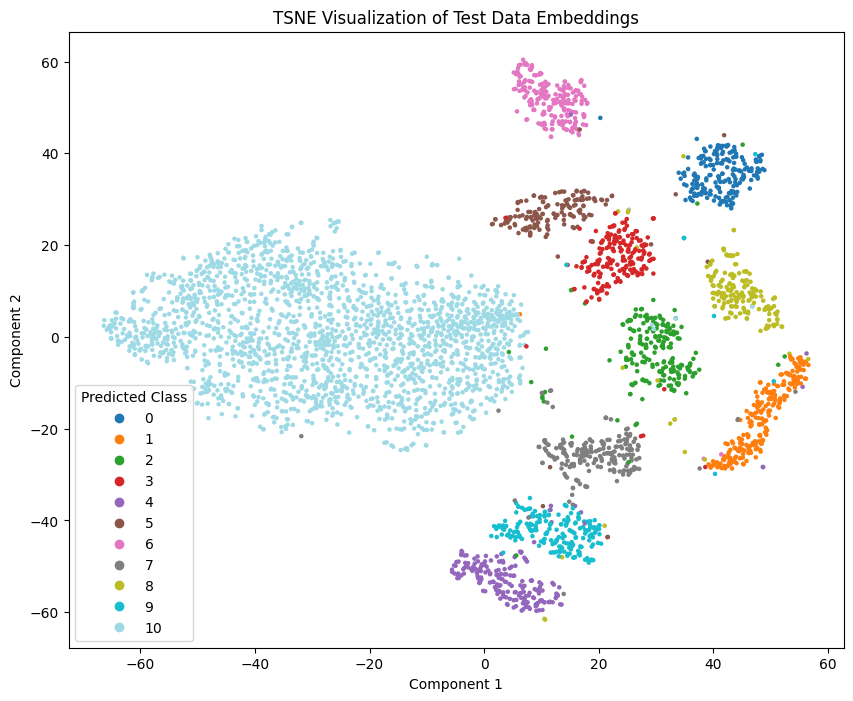

In [161]:
def visualize_embeddings(model, data_loader):
  model.eval()
  embeddings = []
  labels = []
  predictions = []

  with torch.no_grad():
      for data, label in data_loader:
          data, label = data.to(device), label.to(device)
          outputs, _, _, _, _ = model(data)
          embedded_vector = model.encoder(data)
          embedded_vector = embedded_vector.view(embedded_vector.size(0), -1)
          probas, y_pred = torch.max(outputs, 1)
          embeddings.append(embedded_vector.cpu().numpy())
          predictions.append(y_pred.cpu().numpy())

  embeddings = np.concatenate(embeddings, axis=0)
  predictions = np.concatenate(predictions, axis=0)
  reducer = TSNE(n_components=2)
  reduced_embeddings = reducer.fit_transform(embeddings)

  # plot
  discrete_cmap = ListedColormap(plt.cm.tab20(np.linspace(0, 1, 11)))
  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=predictions, cmap=discrete_cmap, s=5)
  plt.legend(*scatter.legend_elements(), title='Predicted Class')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.title('TSNE Visualization of Test Data Embeddings')
  plt.show()

visualize_embeddings(osr_model, combined_ds_loader)

# Evaluation - Unknown Dataset

<ipython-input-165-aed2e9a02346>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  osr_model.load_state_dict(torch.load('./OSR model.pth')['model_state_dict'])
<ipython-input

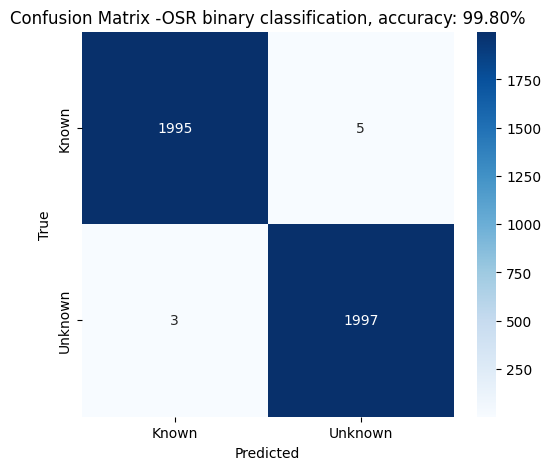

Accuracy on MNIST data: 98.35%
Accuracy on OOD (Unknown) data: 99.85%


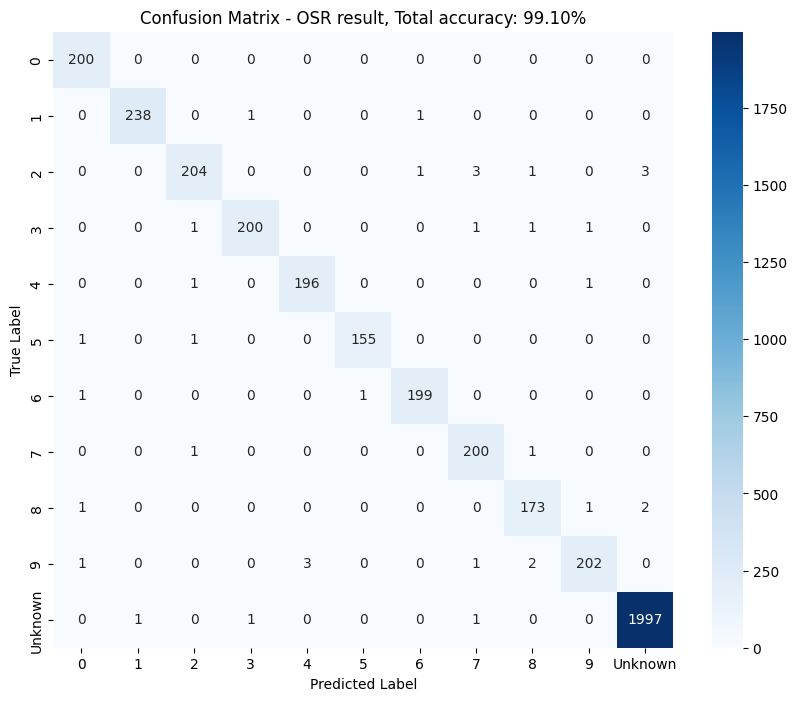

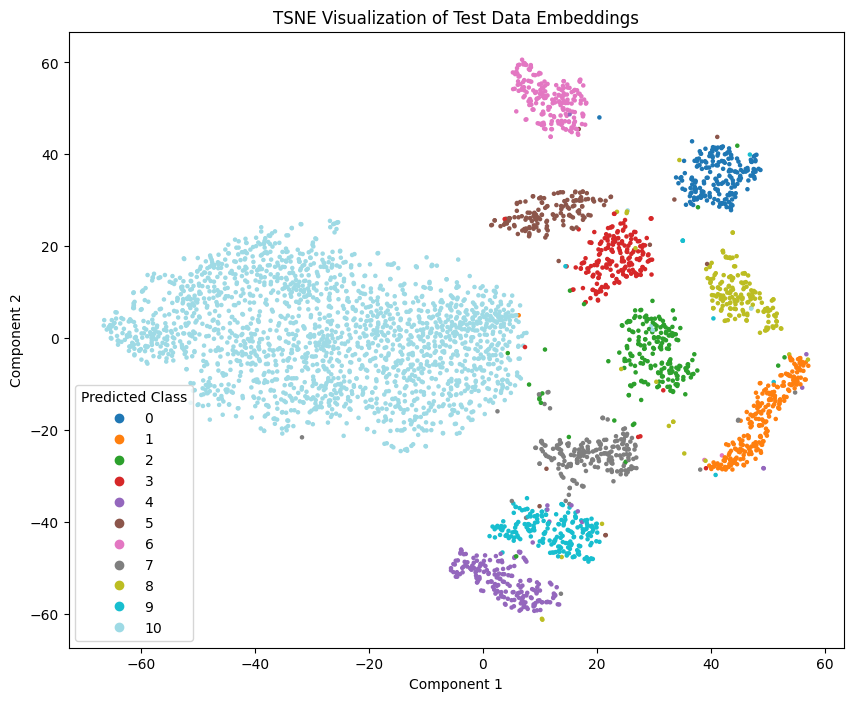

In [165]:
osr_dataset = "" #change to actual path

combined_osr_ds = CombinedDataset(mnist_test_subset, osr_dataset)
combined_osr_ds_loader = DataLoader(combined_osr_ds, batch_size=1024, shuffle=True)

# Load the trained models weights
osr_model = OSR_model()
osr_model.load_state_dict(torch.load('./OSR model.pth')['model_state_dict'])
osr_model.recon_threshold = torch.load('./OSR model.pth')['recon_threshold']
osr_model.to(device)
osr_model.eval()

# OOD results
OOD_res(osr_model, combined_osr_ds_loader)

# OSR results
acc_mnist, acc_ood, acc_total = eval_model(osr_model, combined_osr_ds_loader, device)
OSR_cm(osr_model, combined_osr_ds_loader, acc_mnist, acc_ood, acc_total)

# t-SNE visualization
visualize_embeddings(osr_model, combined_osr_ds_loader)